In [1]:
import datetime
import itertools
import os
import time

# import alphashape
import argparse
# import cartopy.crs as ccrs
import cv2
import hdbscan
import igraph as ig
from matplotlib.path import Path
import matplotlib.pyplot as plt
import metis
# import networkx as nx
import numpy as np


import pickle
import warnings

from concavehull import concavehull
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches
from matplotlib.widgets import CheckButtons, Button, Slider, LassoSelector, RadioButtons, TextBox, RectangleSelector
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from skimage import filters
from sklearn.ensemble import RandomForestClassifier

from hulls import ConcaveHull

import geometry, segmentation as seg


warnings.simplefilter("ignore")

In [2]:
indir = 'unsegmented'
img_0 = np.asarray(plt.imread(f'{indir}/000.tif'))

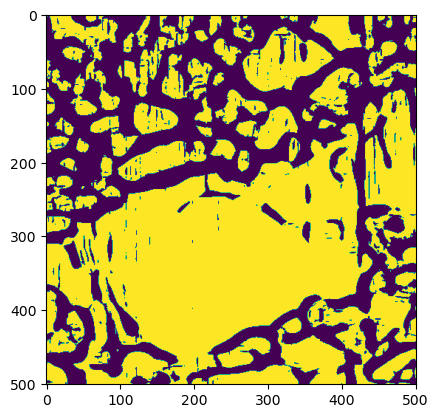

In [3]:
img_01 = seg.neighborhood_average(img_0, d=(5, 5))
fig, ax = plt.subplots()
ax.imshow(filters.meijering(img_01) < 0.1)

In [4]:
img_1 = filters.meijering(img_01)
img_2 = filters.meijering(filters.gaussian(img_1 < 0.05, sigma=5))

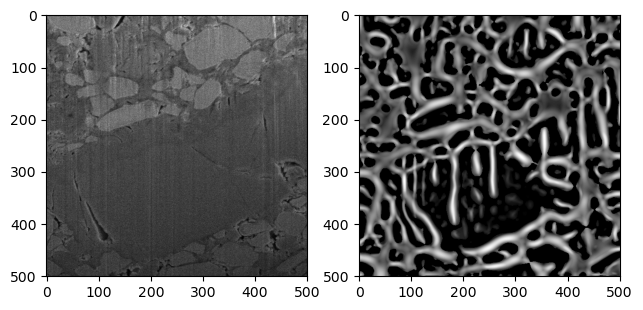

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_0, cmap='gray')
ax[1].imshow(img_2, cmap='gray')
plt.tight_layout()

In [6]:
features = seg.build_features_matrix(img_2, img_0, 0.05)

In [12]:
clusters_0 = seg.get_clustering_results(features[:, :3], **seg.hdbscan_kwargs)

In [13]:
clusters = -1 * np.ones(img_0.shape, dtype=np.int32)

In [14]:
for i in range(features.shape[0]):
    x, y = [int(v) for v in features[i, :2]]
    clusters[x, y] = clusters_0[i]

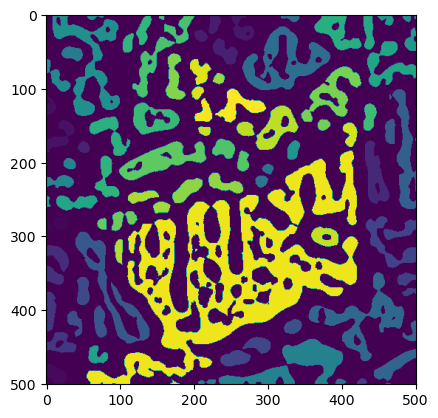

In [15]:
fig, ax = plt.subplots()
ax.imshow(clusters)

*******************-1*******************
*******************0*******************
(77, 2) (501, 501) (501, 501)
(47, 2) (501, 501) (501, 501)
*******************1*******************
*******************2*******************
*******************3*******************
*******************4*******************
*******************5*******************
(85, 2) (501, 501) (501, 501)
(67, 2) (501, 501) (501, 501)
*******************6*******************
*******************7*******************
*******************8*******************
*******************9*******************
*******************10*******************
*******************11*******************
*******************12*******************
*******************13*******************
*******************14*******************
(83, 2) (501, 501) (501, 501)
(61, 2) (501, 501) (501, 501)
*******************15*******************
(347, 2) (501, 501) (501, 501)
(153, 2) (501, 501) (501, 501)
*******************16*******************
(123, 2) (501, 501) (501, 501)

ValueError: shape mismatch: value array of shape (2,) could not be broadcast to indexing result of shape (4567,)

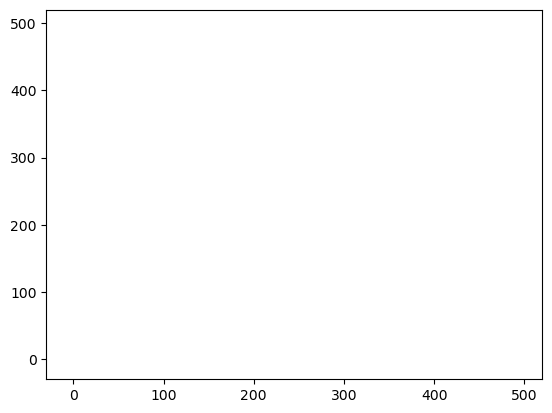

In [31]:
fig, ax = plt.subplots()

new_clusters = -1 * np.ones(clusters.shape, dtype=np.int32)
adder = 0
max_v = np.max(clusters)
for v in np.unique(clusters):
    print(f"*******************{v}*******************")
    if v < 0:
        continue

    coords = np.where(np.isclose(clusters, v))
    points = [(coords[0][i], coords[1][i]) for i in range(coords[0].shape[0])]
    points_arr = np.array(points).reshape(-1, 2)
    points_dict = {}
    for i in range(coords[0].shape[0]):
        points_dict[int(i)] = (int(coords[0][i]), int(coords[1][i]))

    PG = seg.PixelGraph(points=points_dict)
    PG.build_graph()
    PG.get_graph_pieces()
    pieces = PG.pieces
    pieces_extended = pieces.copy()
    n_pieces = PG.n_pieces
    if np.isclose(PG.n_pieces, 1):
        new_clusters[coords] = int(v)
    else:
        for i, p in enumerate(pieces):
            p_points = [points_dict[idx] for idx in p]
            p_points_arr = np.array(p_points).reshape(-1, 2)

            if p_points_arr.shape[0] / (500 ** 2) >= 0.05:
                new_dict = {}
                for k, v in points_dict.items():
                    if int(k) in p:
                        new_dict[k] = v

                graph = seg.PixelGraph(points=new_dict)
                graph.build_graph()
                G = graph.graph
                edgecuts, parts = metis.part_graph(G.to_networkx(), 3, [0.5, 0.3, 0.2])
                new_pieces = [[],[],[]]
                for idx, p in enumerate(parts):
                    new_pieces[int(p)].append(int(idx))
                pieces_extended += new_pieces

        for i, p in enumerate(pieces_extended):
            p_points = [points_dict[idx] for idx in p]
            p_points_arr = np.array(p_points).reshape(-1, 2)

            try:
                hull = concavehull(p_points_arr, chi_factor=1e-12)
                polygon = [(hull[i, 0], hull[i, 1]) for i in range(hull.shape[0])]
                print(hull.shape, new_clusters.shape, inside_points.shape)
                inside_points = seg.polygon_contains(polygon)
                if i == 0:
                    new_clusters[np.where(inside_points == True)] = v
#                     polygon = Polygon(p_points)
                    ax.plot(hull[:, 0] - 5, hull[:, 1] - 5, 'w--', linewidth=0.5)
                else:
                    adder += 1
                    for c in p:
                        new_clusters[points_dict[c]] = max_v + adder
                        # new_clusters[np.where(inside_points == True)] = max_v + adder
            except RuntimeError as e:
                # continue
                # for c in p:
                #     new_clusters[points_dict[c]] = -1
                print(v, i, len(p), e)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(new_clusters)